**Part 1**

In [5]:
import numpy as np
data = np.loadtxt("atlas_z_to_ll.csv",skiprows=1,delimiter=',')

def M(E1,E2,pt1,pt2,eta1,eta2,phi1,phi2):
    px1 = pt1*np.cos(phi1)
    px2 = pt2*np.cos(phi2)
    py1 = pt1*np.sin(phi1)
    py2 = pt2*np.sin(phi2)
    pz1 = pt1*np.sinh(eta1)
    pz2 = pt2*np.sinh(eta2)
    Etot = E1 + E2
    pxtotal = px1+px2
    pytotal = py1+py2
    pztotal = pz1+pz2
    
    return np.sqrt(Etot**2 - ((pxtotal)**2 + (pytotal)**2 + (pztotal)**2))

pt1 = data[:,0]
pt2 = data[:,1]
eta1 = data[:,2]
eta2 = data[:,3]
phi1 = data[:,4]
phi2 = data[:,5]
E1 = data[:,6]
E2 = data[:,7]

Mass = M(E1,E2,pt1,pt2,eta1,eta2,phi1,phi2)
print(Mass)

#M1 = M(E1,pt1,eta1,phi1)
#M2 = M(E2,pt2,eta2,phi2)
#print("Mass 1: ", M1, "Mass 2: ",M2)

[92.1500371  89.28245012 88.2747245  ... 89.49674175 67.40937294
 90.84796693]


Text(0.5, 1.0, 'Counts vs. Mass (kg)')

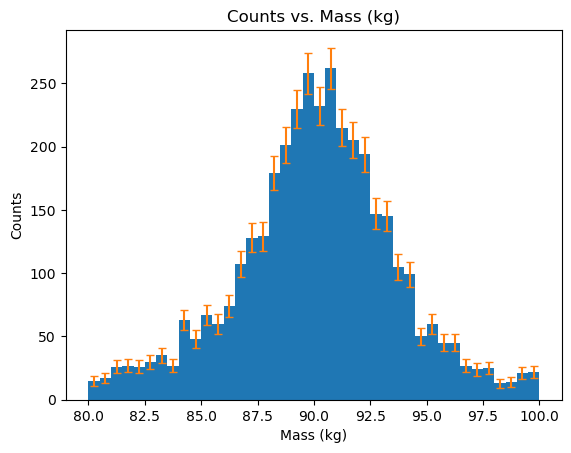

In [6]:
import matplotlib.pyplot as plt 

bins = np.linspace(80,100,41)
hist,bin_edges = np.histogram(Mass,bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


fig, ax = plt.subplots(1,1)
error = np.sqrt(hist)
ax.hist(Mass,bins)
ax.errorbar(bin_centers,hist,yerr=error,capsize=3,ls="")
ax.set_xlabel("Mass (kg)")
ax.set_ylabel("Counts")
ax.set_title("Counts vs. Mass (kg)")

**Part 2**

m0 = 90.34 +- 0.09
ndof = 10, chisq=9.99, pvalue=0.44, reduced chisq=1.00


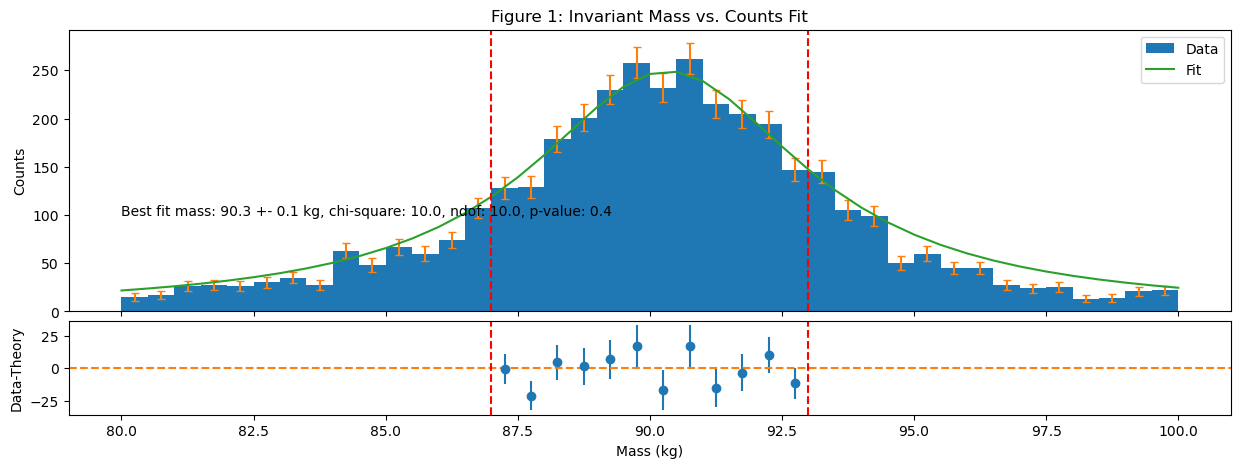

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.optimize import curve_fit

def decay(m,m0,gamma):
    return 2500*(1/np.pi)*(gamma/2)/((m-m0)**2+(gamma/2)**2)

mask = (bin_centers > 87) & (bin_centers < 93)

params, covar = curve_fit(f=decay, xdata=bin_centers[mask], ydata=hist[mask], sigma=error[mask], absolute_sigma=True)

m0 = params[0]
gamma = params[1]
m = bins

D_plot = decay(m,m0,gamma)

residuals = hist[mask] - decay(bin_centers[mask],*params)

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, sharex=True, figsize=(15, 5),
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05}
)

chisq =  np.sum(((hist[mask] - decay(bin_centers[mask],*params))/error[mask])**2)
dof = len(bin_centers[mask]) - 2
pvalue = st.chi2.sf(chisq, dof)
red_chisq = chisq/dof

m0 = params[0]
m0_err = np.sqrt(covar[0][0])
print(f"m0 = {m0:.2f} +- {m0_err:.2f}")

print(f"ndof = {dof}, chisq={chisq:.2f}, pvalue={pvalue:.2f}, reduced chisq={red_chisq:.2f}")

ax_top.hist(Mass,bins,label="Data")
ax_top.errorbar(bin_centers,hist,yerr=error,capsize=3,ls="")
ax_top.plot(bins,D_plot,label="Fit")
ax_top.set_xlabel("Mass (kg)")
ax_top.set_ylabel("Counts")
ax_top.set_title("Figure 1: Invariant Mass vs. Counts Fit")
ax_top.legend()

ax_bot.errorbar(bin_centers[mask], residuals, yerr=error[mask], fmt='o', color='C0')
ax_bot.axhline(0, color='C1', linestyle='--')
ax_bot.set_xlabel("Mass (kg)")
ax_bot.set_ylabel("Data-Theory")

ax_top.axvline(87,ls='--',color='red')
ax_top.axvline(93,ls='--',color='red')
ax_top.text(80,100,f"Best fit mass: {m0:.1f} +- {m0_err:.1f} kg, chi-square: {chisq:.1f}, ndof: {dof:.1f}, p-value: {pvalue:.1f}")

ax_bot.axvline(87,ls='--',color='red')
ax_bot.axvline(93,ls='--',color='red')

**Part 3**

<a list of 2 text.Text objects>

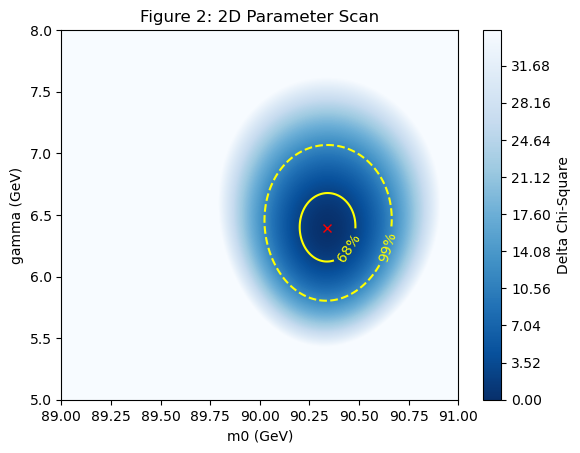

In [50]:
n_bins = 300
chi_map = np.zeros((n_bins,n_bins))
m0_span = np.linspace(89,91,n_bins)
gamma_span = np.linspace(5,8,n_bins)

# the double for loop
for i in range(n_bins):
    for j in range(n_bins):
        theory = 2500*(1/np.pi)*(gamma_span[j]/2)/((bin_centers[mask]-m0_span[i])**2+(gamma_span[j]/2)**2)
        chi2 = np.sum((theory-hist[mask])**2/error[mask]**2)
        chi_map[j,i] = chi2

chi_min = np.min(chi_map)
chi_map = np.clip(chi_map,chi_min,chi_min+35) # clip (trims off all numbers bigger than 35) to 35
delta_chi_map = chi_map - chi_min 

X,Y = np.meshgrid(m0_span,gamma_span)
fig2,ax2 = plt.subplots(1,1)
cs = ax2.contourf(X,Y,delta_chi_map,500, cmap="Blues_r")
ax2.set_xlabel("m0 (GeV)")
ax2.set_ylabel("gamma (GeV)")
cbar = fig2.colorbar(cs, ax=ax2)
cbar.set_label("Delta Chi-Square")

levels = [2.30,11.8]
CS = ax2.contour(X,Y,delta_chi_map,levels=levels,colors=["yellow", "yellow"], linestyles=["solid","dashed"])

ax2.plot(m0,gamma, "x",color='red')
ax2.set_title("Figure 2: 2D Parameter Scan")

fmt={}
strs = ['68%','99%']
for l, s in zip(CS.levels,strs):
    fmt[l]=s
ax2.clabel(CS,CS.levels,inline=True,fmt=fmt)

In [51]:
from scipy.stats import chi2
print("Level 3sigma",chi2.ppf(0.9973,2)) # how we got the 11.8 parameter for the outer limit of levels

Level 3sigma 11.82900701194368
